In [1]:
%matplotlib inline
%matplotlib widget


import operator
import cc3d
from fran.utils.imageviewers import ImageMaskViewer
from fastai.vision.augment import ToTensor, typedispatch
from fran.transforms.spatialtransforms import one_hot
from fran.utils.common import *
import SimpleITK as sitk
from monai.metrics import *
import functools as fl
import itertools as il

In [2]:

@typedispatch
def img_shape(x:sitk.Image):
   return x.GetSize()

@typedispatch
def img_shape(x:torch.Tensor):
   return x.shape

@ToTensor
def encodes(self,x:sitk.Image): 
   x_np = sitk.GetArrayFromImage(x)
   x_pt = torch.from_numpy(x_np)
   return x_pt

In [3]:
if __name__ == "__main__":
    P = Project(project_title="lits")
    proj_defaults= P.proj_summary

In [4]:
    configs_excel = ConfigMaker(proj_defaults.configuration_filename,raytune=False).config
    train_list, valid_list, test_list = get_fold_case_ids(
            fold=configs_excel['metadata']["fold"],
            json_fname=proj_defaults.validation_folds_filename,
        )



In [5]:
    mask_files = list((proj_defaults.raw_data_folder/("masks")).glob("*nii*"))
    img_files= list((proj_defaults.raw_data_folder/("images")).glob("*nii*"))
    masks_valid = [filename for filename in mask_files if  get_case_id_from_filename(proj_defaults.project_title, filename) in valid_list]
    masks_train = [filename for filename in mask_files if  get_case_id_from_filename(proj_defaults.project_title, filename) in train_list]
    imgs_valid =  [proj_defaults.raw_data_folder/"images"/mask_file.name for mask_file in masks_valid]
    imgs_test =  [filename for filename in img_files if  get_case_id_from_filename(proj_defaults.project_title, filename) in test_list]
    imgs_train =  [filename for filename in img_files if  get_case_id_from_filename(proj_defaults.project_title, filename) in train_list]

In [6]:
    run_name = "LITS-122"
    preds_folder = list(proj_defaults.predictions_folder.glob(f"*{run_name}"))[0]
    pred_fns = list(preds_folder.glob("*"))
    pred_fn = pred_fns[0]
    case_id = get_case_id_from_filename('lits',pred_fn)

In [7]:
    
    mask_fn = [fn for fn in masks_train if 'lits-128' in str(fn)][0]
    img_fn = [fn for fn in imgs_train if 'lits-128' in str(fn)][0]

In [8]:

    img = sitk.ReadImage(img_fn)
    img_np= sitk.GetArrayFromImage(img)
    img_pt = torch.tensor(img_np)

In [9]:
    pred= sitk.ReadImage(pred_fn)
    pred_np = sitk.GetArrayFromImage(pred)

In [10]:
    mask = sitk.ReadImage(mask_fn)
    mask_np= sitk.GetArrayFromImage(mask)
    mask_pt = torch.tensor(mask_np)
    mask_np[mask_np==1] =0

In [11]:
    labels_org, N = cc3d.connected_components(mask_np, return_N=True) 
    labels_pred, N = cc3d.connected_components(pred_np, return_N=True) 
    stats_pred  = cc3d.statistics(labels_pred)
    stats_org = cc3d.statistics(labels_org)
    centroids_org, centroids_pred = [stats['centroids'][1:] for stats in [stats_pred,stats_org]]

In [12]:
    
    spacings = pred.GetSpacing()
    spacings_np = spacings[::-1]
    voxvol = fl.reduce(operator.mul,spacings)

/home/ub/Dropbox/code/fran/fran/utils/imageviewers.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


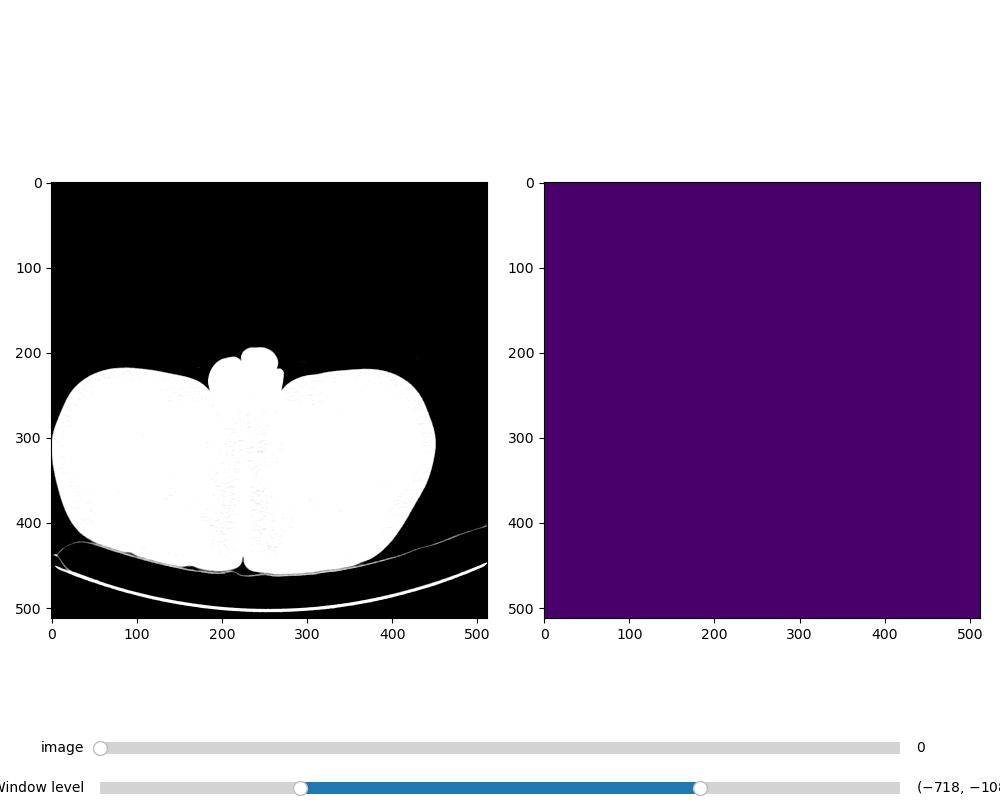

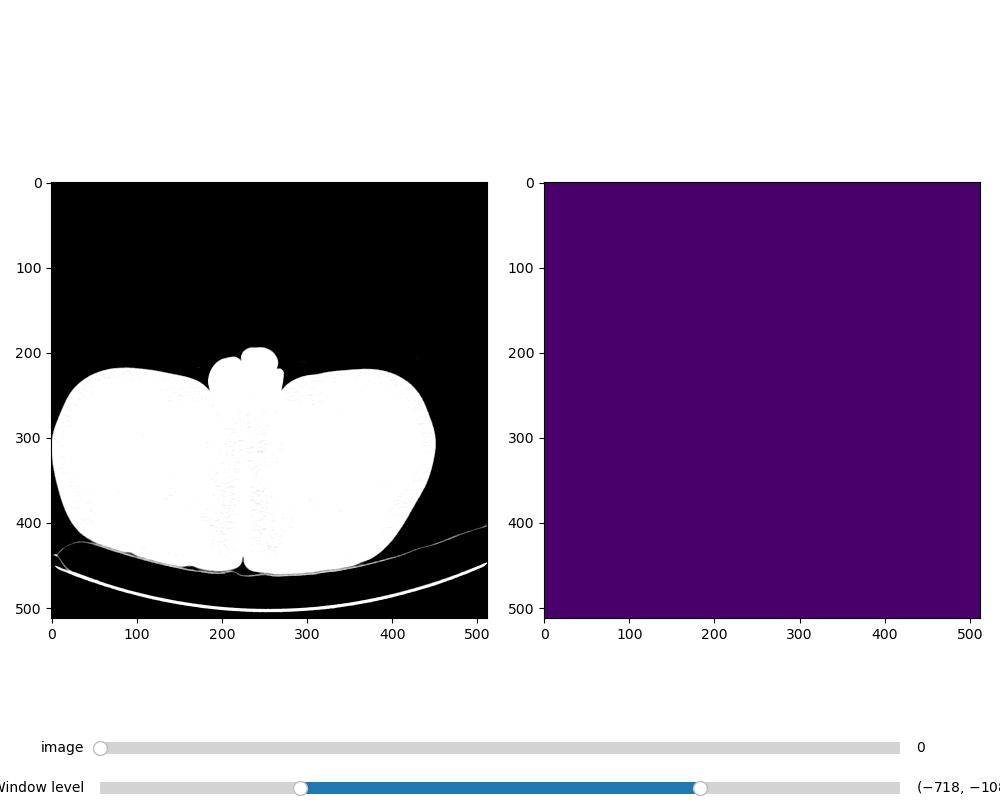

In [13]:
ImageMaskViewer([img_np,labels_org],data_types=['img','mask']) # 


In [ ]:
ImageMaskViewer([img_np,labels_pred],data_types=['img','mask']) # 
n_classes = 3

# Dice score

In [ ]:

mask_pt = ToTensor.encodes(mask)
pred_pt = ToTensor.encodes(pred)
pred_onehot = one_hot(pred_pt,classes=n_classes,axis=0)
pred_onehot = pred_onehot.unsqueeze(0)
pred_onehot,mask_onehot = [one_hot(x,classes=n_classes,axis=0).unsqueeze(0) for x in [pred_pt,mask_pt]]
aa = compute_dice(pred_onehot,mask_onehot)

In [ ]:
ImageMaskViewer([pred_pt,mask_pt],data_types=['mask','mask'])